In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(load_data(datadir))

train_X = data.train.fingerprints
validation_X = data.validation.fingerprints
test_X = data.test.fingerprints

train_STD = data.train.y_err
validation_STD = data.validation.y_err

train_Y = data.train.y
validation_Y = data.validation.y
test_Y = data.test.y

## Augmented Data

In [3]:
n_samples = 16

augmented_train_X = np.tile(train_X, (n_samples, 1))

augmented_train_Y = np.concatenate([
    train_Y + np.random.randn(*train_Y.shape) * train_STD
    for _ in range(n_samples)
])

## XGB Model

In [4]:
with open('./hyperparameters.json') as f:
    hyperparameters = json.load(f)

In [5]:
multi_xgbr = MultiOutputRegressor(
    XGBRegressor(**hyperparameters)
)
multi_xgbr.fit(augmented_train_X, augmented_train_Y)
print(f'Score: {multi_xgbr.score(test_X, test_Y)}')

Score: 0.08177867566666006


## Test

In [6]:
x = test_X
y_true = test_Y

In [7]:
y_pred = multi_xgbr.predict(x)
scores = r2_score(y_true, y_pred, multioutput='raw_values')
print(scores)

[ 0.19205753  0.01412898  0.07937419  0.08880186  0.06498851 -0.02896013
  0.16205979]


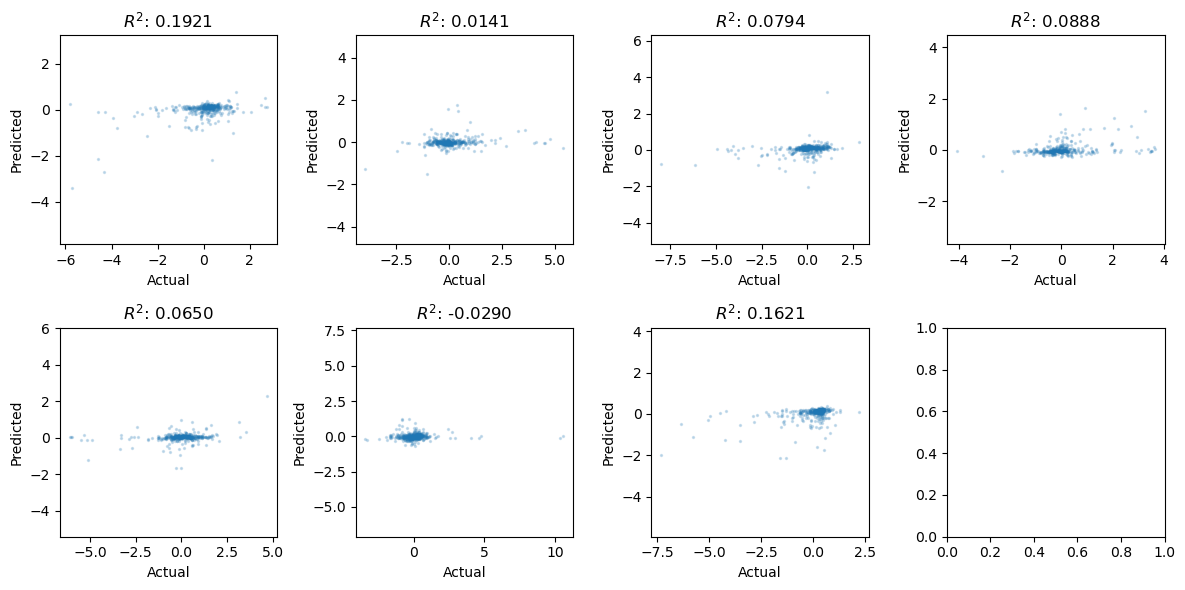

In [9]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i], y_pred[:, i], s=2, alpha=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()

In [ ]:
#fig.savefig('./figures/predictions.pdf')